# Alignment and Party Assortation

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

download("https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/v1/utils.py")

In [2]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import decorate, make_lowess, plot_series_lowess

In [4]:
download(
    "https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/v1/gss_pacs_resampled.hdf"
)

In [5]:
def chunk_series(df, xvarname, yvarname, n=50):
    """Break a population into chunks and compute a mean for each chunk.

    Sort by `xvarname`, break into chunks, and compute the mean of column `yvarname`

    df: DataFrame
    xvarname: variable
    yvarname: variable
    size: chunk size

    returns: pd.Series
    """
    subset = df[[xvarname, yvarname]].dropna().sort_values(by=xvarname).reset_index()
    size = int(len(df) // n) + 1
    subset["chunk"] = subset.index // size
    groupby = subset.groupby("chunk")
    x = groupby[xvarname].mean()
    y = groupby[yvarname].mean()

    return pd.Series(y.values, x)

In [6]:
def decorate_anchor(**options):
    decorate(**options)
    anchor_legend(1.02, 1.02)

## Load the data

In [7]:
datafile = "gss_pacs_resampled.hdf"
gss = pd.read_hdf(datafile, "gss0")
gss.shape

(72390, 207)

In [8]:
gss["polviews"].value_counts()

4.0    24157
5.0     9816
6.0     9612
3.0     7799
2.0     7309
7.0     2145
1.0     2095
Name: polviews, dtype: int64

In [9]:
columns = [
    "Extremely liberal",
    "Liberal",
    "Slightly liberal",
    "Moderate",
    "Slightly conservative",
    "Conservative",
    "Extremely conservative",
]

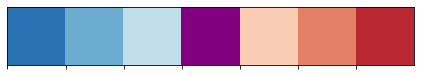

In [10]:
palette = sns.color_palette("RdBu_r", 7)
palette[3] = "purple"
sns.palplot(palette)

In [11]:
color_map = dict(zip(columns, palette))

In [12]:
# recode the 7 point scale with words
d7 = dict(zip(range(1, 8), columns))
polviews7 = gss["polviews"].replace(d7)

In [13]:
xtab = pd.crosstab(gss["year"], polviews7, normalize="index") * 100

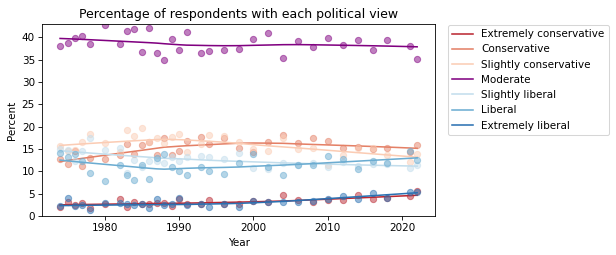

In [14]:
for column in reversed(columns):
    plot_series_lowess(xtab[column], color_map[column])

decorate(
    xlabel="Year",
    ylabel="Percent",
    ylim=[0, 43],
    title="Percentage of respondents with each political view",
)

plt.legend(bbox_to_anchor=(1.02, 1.02))
plt.savefig("alignment1.jpg", dpi=600)

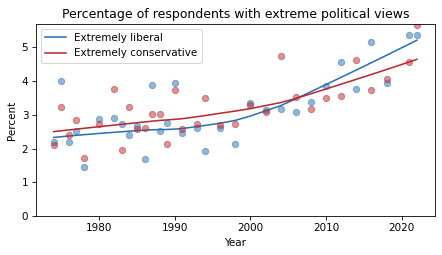

In [15]:
selected_columns = ["Extremely liberal", "Extremely conservative"]

for column in selected_columns:
    plot_series_lowess(xtab[column], color_map[column])

decorate(
    xlabel="Year",
    ylabel="Percent",
    ylim=[0, 5.7],
    title="Percentage of respondents with extreme political views",
)
plt.savefig("alignment2.jpg", dpi=600)

## But what do people think?

In [16]:
convervative_values = {
    "abany": [2],
    "homosex": [1, 2, 3],
    "premarsx": [1, 2, 3],
    "prayer": [2],
    "natfare": [3],
    "grass": [2],
    "natenvir": [2, 3],  # about right or too much
    "divlaw": [2],
    "cappun": [1],
    "racopen": [1],
    "letdie1": [2],
    "fepol": [1],
    "gunlaw": [2],
    "sexeduc": [2],
    "pornlaw": [1],
}

len(convervative_values)

15

In [17]:
order = [
    "homosex",
    "cappun",
    "grass",
    "abany",
    "prayer",
    "premarsx",
    "divlaw",
    "natfare",
    "natenvir",
    "pornlaw",
    "racopen",
    "letdie1",
    "fepol",
    "gunlaw",
    "sexeduc",
]

In [18]:
questions = pd.DataFrame(dtype=int)

for varname in order:
    questions[varname] = gss[varname].isin(convervative_values[varname])
    null = gss[varname].isna()
    questions.loc[null, varname] = np.nan

questions.mean().sort_values()

sexeduc     0.123886
gunlaw      0.250978
fepol       0.282706
letdie1     0.315200
pornlaw     0.363225
racopen     0.375268
natenvir    0.379694
natfare     0.466692
divlaw      0.483160
premarsx    0.532401
abany       0.584113
prayer      0.589092
grass       0.676471
homosex     0.694179
cappun      0.699517
dtype: float64

In [19]:
recode_polviews = {
    1: "Liberal",
    2: "Liberal",
    3: "Liberal",
    4: "Moderate",
    5: "Conservative",
    6: "Conservative",
    7: "Conservative",
}

In [20]:
gss["polviews3"] = gss["polviews"].replace(recode_polviews)

In [21]:
augmented = pd.concat([questions, gss["polviews3"]], axis=1)
table = augmented.groupby("polviews3").mean().transpose() * 100
table

polviews3,Conservative,Liberal,Moderate
homosex,80.078472,52.133345,69.486686
cappun,79.034668,56.034700,72.225235
grass,75.183941,53.870761,67.359822
abany,69.519140,41.606774,58.463817
prayer,66.707264,43.282408,61.876856
premarsx,64.039842,37.861350,51.134103
divlaw,57.645939,37.325430,47.405560
natfare,57.750107,33.333333,47.156326
natenvir,48.847487,25.012968,37.054686
pornlaw,43.930966,24.633269,35.401601


In [22]:
(table["Conservative"] - table["Liberal"]).sort_values()

sexeduc     11.569155
fepol       11.987859
gunlaw      14.176060
racopen     14.482003
letdie1     14.694901
pornlaw     19.297697
divlaw      20.320510
grass       21.313180
cappun      22.999969
prayer      23.424856
natenvir    23.834519
natfare     24.416774
premarsx    26.178492
abany       27.912366
homosex     27.945127
dtype: float64

In [23]:
issue_dict = {
    "abany": "Abortion",
    "homosex": "Homosexuality",
    "premarsx": "Premarital sex",
    "prayer": "School prayer",
    "natfare": "Welfare spending",
    "grass": "Legal cannabis",
    "natenvir": "Environment",
    "divlaw": "Divorce",
    "cappun": "Capital punishment",
    "racopen": "Fair housing law",
    "letdie1": "Assisted suicide",
    "fepol": "Women in politics",
    "gunlaw": "Gun law",
    "sexeduc": "Sex education",
    "pornlaw": "Pornography",
}

issue_names = pd.Series(issue_dict)[order].values

For each question, I identified the responses more likely to be chosen by conservatives.
The following figure shows, for each question, the percentage of liberals, moderates, and conservatives who chose one of the conservative responses.

In [24]:
polview_names = ["Conservative", "Moderate", "Liberal"]
party_names = ["Republican", "Nonpartisan", "Democrat"]

marker_map = dict(zip(polview_names, ["s", "^", "o"]))
line_map = dict(zip(polview_names, ["--", "-.", ":"]))

In [25]:
muted = sns.color_palette("muted", 5)
polview_map = dict(zip(polview_names, [muted[3], muted[4], muted[0]]))
party_map = dict(zip(party_names, [muted[3], muted[4], muted[0]]))



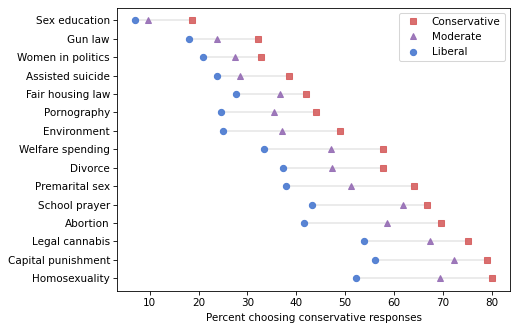

In [26]:
plt.figure(figsize=(7, 4.5))
plt.hlines(
    issue_names,
    table["Liberal"],
    table["Conservative"],
    color="gray",
    alpha=0.2,
)

for polviews, color in polview_map.items():
    x = table[polviews]
    marker = marker_map[polviews]
    plt.plot(x, issue_names, marker, color=color, alpha=0.9, label=polviews)

decorate(xlabel="Percent choosing conservative responses")
plt.savefig("alignment3.jpg", dpi=600)

In [27]:
# some questions are "easier" than others; we can use the logit of the prevalence
# for each question to estimate its difficulty

from scipy.special import logit

difficulty = -logit(questions.mean())
difficulty

homosex    -0.819729
cappun     -0.844997
grass      -0.737602
abany      -0.339681
prayer     -0.360215
premarsx   -0.129786
divlaw      0.067387
natfare     0.133429
natenvir    0.490847
pornlaw     0.561395
racopen     0.509683
letdie1     0.775920
fepol       0.931077
gunlaw      1.093402
sexeduc     1.956132
dtype: float64

In [28]:
# if we make a mesh with one row for each efficacy and one column for each question,
# we can make a mapping from each efficacy to the number of conservative answers we
# expect from a person with each efficacy

from scipy.special import expit

xs = np.linspace(-6, 6, 21)
X, D = np.meshgrid(xs, difficulty)
P = expit(X - D)
Q = 1 - P
ns = P.sum(axis=0)

In [29]:
# as a prior for efficacy, I'll use a wide Gaussian, which represents
# a gentle bias toward the middle of the range

from scipy.stats import norm
from empiricaldist import Pmf

ys = norm.pdf(xs, 0, 4)
prior = Pmf(ys, xs)
prior.normalize()

1.4751408263256967

In [30]:
# compute the results for all respondents with a single 3-D array:
# one row for each respondent,
# one column for each question,
# one page for each hypothetical value of efficacy

n, m = questions.shape
size = n, m, len(xs)
res = np.empty(size)
res.shape

(72390, 15, 21)

In [31]:
# now we can fill the array with the likelihoods of conservative and non-conservative
# responses; where there's a NaN, we fill in all 1

a = questions.fillna(2).astype(int).values
ii, jj = np.nonzero(a == 0)
res[ii, jj, :] = Q[jj]
ii, jj = np.nonzero(a == 1)
res[ii, jj, :] = P[jj]
ii, jj = np.nonzero(a == 2)
res[ii, jj, :] = 1

In [32]:
# multiplying along the rows gives the likelihood of each row of responses,
# which we multiply by the prior probabilities

product = res.prod(axis=1) * prior.values
product.shape

(72390, 21)

In [33]:
# normalize the rows to get a posterior distribution for each respondent

posterior = product / product.sum(axis=1)[:, None]
posterior.shape

(72390, 21)

In [34]:
# compute the means of the posterior distributions

con = (posterior * ns).sum(axis=1)
con.shape

(72390,)

In [35]:
# and the variances of the posterior distributions

deviations = ns - con[:, None]
var_con = (posterior * deviations**2).sum(axis=1)
std_con = np.sqrt(var_con)
std_con.shape

(72390,)

In [36]:
answered = questions.notna().sum(axis=1)
(answered >= 5).mean()

0.9071833126122393

In [37]:
gss["conservatism"] = pd.Series(con, gss.index) + np.random.normal(0, 0.2, len(con))
gss.loc[answered < 5, "conservatism"] = np.nan
gss["conservatism"].describe()

count    65671.000000
mean         6.818951
std          3.231910
min         -0.128472
25%          4.426938
50%          6.824761
75%          9.213493
max         15.011929
Name: conservatism, dtype: float64

## Change in location and spread

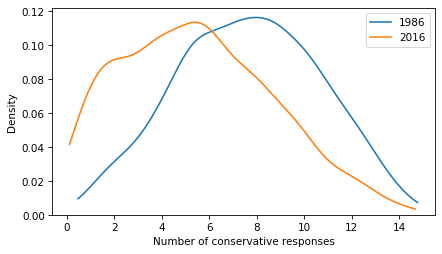

In [38]:
by_year = gss.groupby("year")

selected_years = [1986, 2016]
for year in selected_years:
    group = by_year.get_group(year)
    sns.kdeplot(group["conservatism"], cut=0, bw_adjust=1.3, label=year)

decorate(xlabel="Number of conservative responses")
plt.savefig("alignment4.jpg", dpi=600)

In [39]:
series_conservatism = gss.groupby("year")["conservatism"].mean()
series_conservatism.loc[selected_years]

year
1986    7.635216
2016    5.499032
Name: conservatism, dtype: float64

In [40]:
def highlight_years(series, years):
    plt.plot(series.loc[years], "x", color="C4")

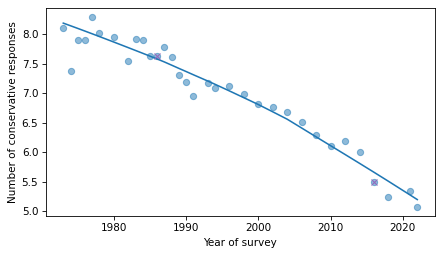

In [41]:
plot_series_lowess(series_conservatism, color="C0")
highlight_years(series_conservatism, selected_years)

decorate(xlabel="Year of survey",
         ylabel="Number of conservative responses",
         legend=False)
plt.savefig("alignment5.jpg", dpi=600)

In [42]:
std_year = gss.groupby("year")["conservatism"].std()
std_year.loc[selected_years]

year
1986    2.993371
2016    3.197281
Name: conservatism, dtype: float64

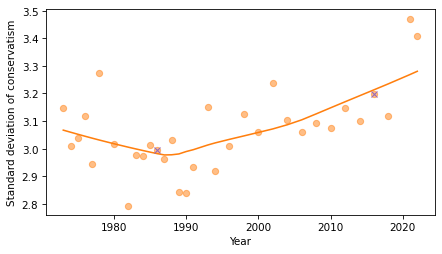

In [43]:
plot_series_lowess(std_year, "C1")
highlight_years(std_year, selected_years)
decorate(xlabel="Year", 
         ylabel="Standard deviation of conservatism",
         legend=False)
plt.savefig("alignment6.jpg", dpi=600)

In [44]:
def compute_mad(seq):
    con = seq.dropna()
    if len(con) == 0:
        return np.nan
    X, Y = np.meshgrid(con, con)
    return np.abs(X - Y).mean()

In [45]:
series_mad = pd.Series(dtype=float)
for name, group in gss.groupby("year"):
    con = group["conservatism"].dropna()
    series_mad.loc[name] = compute_mad(con)

In [46]:
series_mad = gss.groupby("year")["conservatism"].agg(compute_mad)
series_mad.loc[selected_years]

year
1986    3.419892
2016    3.640552
Name: conservatism, dtype: float64

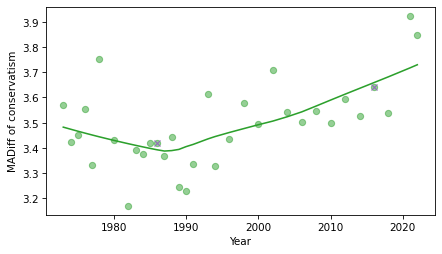

In [47]:
plot_series_lowess(series_mad, color="C2")
highlight_years(series_mad, selected_years)
decorate(xlabel="Year", ylabel="MADiff of conservatism", legend=False)
plt.savefig("alignment7.jpg", dpi=600)

## Conservatism by polviews

In [48]:
table = gss.pivot_table(
    index="year", columns="polviews3", values="conservatism", aggfunc=compute_mad
)

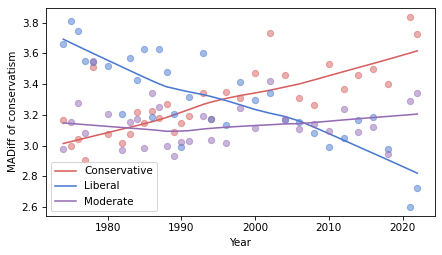

In [49]:
columns = ["Conservative", "Liberal", "Moderate"]
for column in columns:
    plot_series_lowess(table[column], polview_map[column])

decorate(
    xlabel="Year",
    ylabel="MADiff of conservatism",
)

## Polarization by party

In [50]:
recode_party = {
    0: "Strong democrat",
    1: "Not very strong democrat",
    2: "Independent, close to democrat",
    3: "Independent",
    4: "Independent, close to republican",
    5: "Not very strong republican",
    6: "Strong republican",
    7: np.nan,
}
gss["party7"] = gss["partyid"].replace(recode_party)
gss["party7"].value_counts()

Not very strong democrat            14360
Independent                         11510
Strong democrat                     11250
Not very strong republican          10875
Independent, close to democrat       8376
Strong republican                    7446
Independent, close to republican     6740
Name: party7, dtype: int64

In [51]:
columns = list(recode_party.values())[:-1]
columns

['Strong democrat',
 'Not very strong democrat',
 'Independent, close to democrat',
 'Independent',
 'Independent, close to republican',
 'Not very strong republican',
 'Strong republican']

In [52]:
color_map = dict(zip(columns, palette))

In [53]:
xtab = pd.crosstab(gss["year"], gss["party7"], normalize="index") * 100

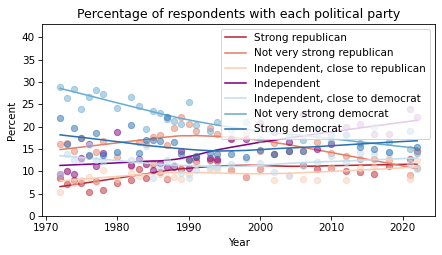

In [54]:
for column in reversed(columns):
    plot_series_lowess(xtab[column], color_map[column])

decorate(
    xlabel="Year",
    ylabel="Percent",
    ylim=[0, 43],
    title="Percentage of respondents with each political party",
)

plt.savefig("alignment8.jpg", dpi=600)

In [55]:
recode_party = {
    0: "Democrat",
    1: "Democrat",
    2: "Nonpartisan",
    3: "Nonpartisan",
    4: "Nonpartisan",
    5: "Republican",
    6: "Republican",
    7: np.nan,
}
gss["party3"] = gss["partyid"].replace(recode_party)
gss["party3"].value_counts()

Nonpartisan    26626
Democrat       25610
Republican     18321
Name: party3, dtype: int64

In [56]:
xtab = pd.crosstab(gss["year"], gss["party3"], normalize="index") * 100
xtab.head()

party3,Democrat,Nonpartisan,Republican
year,,,
1972,50.968992,24.354005,24.677003
1973,42.592593,33.903134,23.504274
1974,48.089402,29.199712,22.710887
1975,41.508152,33.491848,25.000000
1976,40.321500,40.723376,18.955124


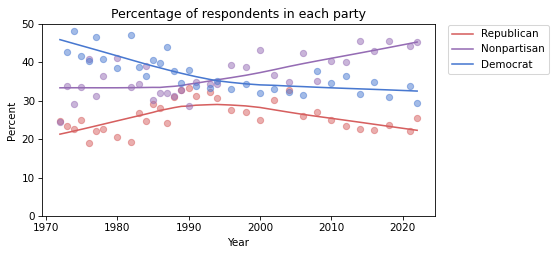

In [57]:
for column in party_names:
    plot_series_lowess(xtab[column], party_map[column])

decorate(
    xlabel="Year",
    ylabel="Percent",
    ylim=[0, 50],
    title="Percentage of respondents in each party",
)

plt.legend(bbox_to_anchor=(1.02, 1.02))
plt.savefig("alignment9.jpg", dpi=600)

In [58]:
table = gss.pivot_table(index="year", columns="party3", values="conservatism")
table

party3,Democrat,Nonpartisan,Republican
year,,,
1973,7.795799,7.604572,9.335992
1974,7.167925,6.937392,8.510388
1975,7.747279,7.189447,9.092206
1976,8.099246,7.376789,8.641372
1977,8.279987,7.727174,9.174550
1978,7.964510,7.498627,8.912556
1980,7.863107,7.438121,9.215763
1982,7.423017,7.338630,8.159167
1983,7.676475,7.546467,8.712906


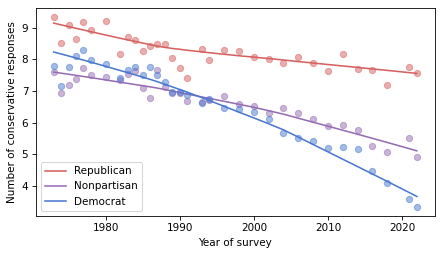

In [59]:
for column in party_names:
    plot_series_lowess(table[column], color=party_map[column])

decorate(xlabel="Year of survey", ylabel="Number of conservative responses")
plt.savefig("alignment10.jpg", dpi=600)

In [60]:
for column, series in table.items():
    smooth = make_lowess(series)
    diff = smooth.iloc[-1] - smooth.iloc[1]
    print(column, diff)

Democrat -4.487673742695614
Nonpartisan -2.453195767290058
Republican -1.5482436384302316


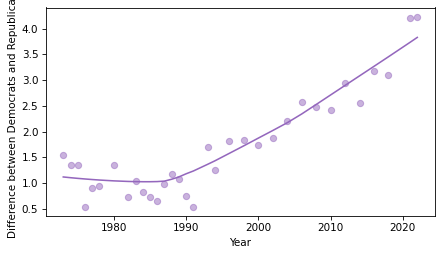

In [61]:
diff = table["Republican"] - table["Democrat"]
plot_series_lowess(diff, "C4")
decorate(xlabel="Year", ylabel="Difference between Democrats and Republicans")
plt.savefig("alignment11.jpg", dpi=600)

In [62]:
def compare_kde_plots(df):
    for name, group in df.groupby("party3"):
        sns.kdeplot(
            group["conservatism"],
            color=party_map[name],
            label=name,
            cut=0,
            bw_adjust=1.3,
        )

    decorate(xlabel="Number of conservative responses")

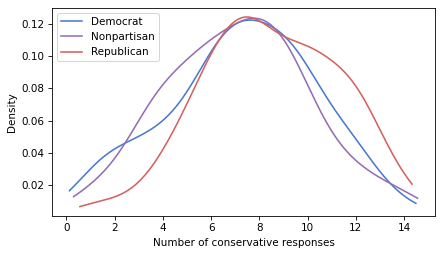

In [63]:
compare_kde_plots(gss.query("year==1988"))
plt.savefig("alignment12.jpg", dpi=600)

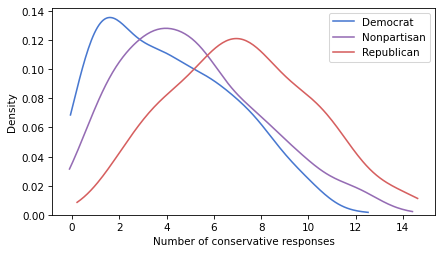

In [64]:
compare_kde_plots(gss.query("year==2018"))
plt.savefig("alignment13.jpg", dpi=600)

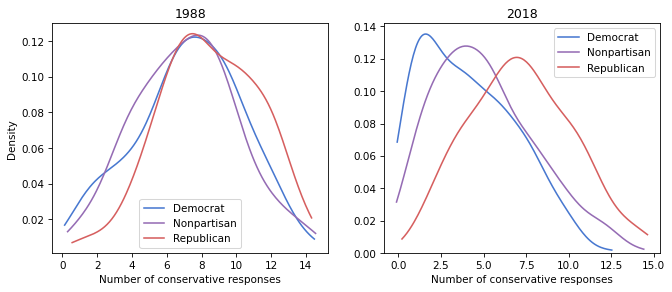

In [65]:
plt.figure(figsize=(9, 4))

for i, year in enumerate([1988, 2018]):
    plt.subplot(1, 2, i + 1)
    compare_kde_plots(gss.query(f"year=={year}"))
    plt.title(year)
    if i == 1:
        plt.ylabel("")

plt.savefig("alignment13.jpg", dpi=600)

## Correlation

In [66]:
series_corr = (
    gss.groupby("year")[["conservatism", "partyid"]]
    .corr()["conservatism"]
    .xs("partyid", level=1)
)

In [67]:
make_lowess(series_corr)

1973.0    0.115622
1974.0    0.116631
1975.0    0.117765
1976.0    0.119009
1977.0    0.120343
1978.0    0.121750
1980.0    0.124783
1982.0    0.128177
1983.0    0.130054
1984.0    0.132111
1985.0    0.134466
1986.0    0.137507
1987.0    0.143163
1988.0    0.149613
1989.0    0.157334
1990.0    0.164511
1991.0    0.172101
1993.0    0.189355
1994.0    0.198083
1996.0    0.215875
1998.0    0.233721
2000.0    0.250751
2002.0    0.266292
2004.0    0.281832
2006.0    0.296517
2008.0    0.312880
2010.0    0.329575
2012.0    0.346229
2014.0    0.362747
2016.0    0.379118
2018.0    0.395393
2021.0    0.419831
2022.0    0.428039
dtype: float64

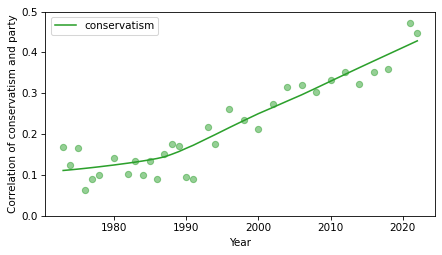

In [68]:
plot_series_lowess(series_corr, color="C2")
decorate(xlabel="Year", ylabel="Correlation of conservatism and party", ylim=[0, 0.5])
plt.savefig("alignment14.jpg", dpi=600)

In [69]:
n = len(gss)
gss["party_jitter"] = gss["partyid"].replace(7, np.nan) + np.random.normal(0, 0.5, n)
gss["con_jitter"] = gss["conservatism"] + np.random.normal(0, 0.2, n)

In [70]:
yticks = range(7)
ylabels = [
    "Strong democrat",
    "Not very strong democrat",
    "Independent, close to democrat",
    "Independent (neither, no response)",
    "Independent, close to republican",
    "Not very strong republican",
    "Strong Republican",
]

In [71]:
grouped = gss.groupby("year")

In [72]:
def make_scatter(year):
    group = grouped.get_group(year)
    plt.plot(group["con_jitter"], group["party_jitter"], "o", color="C1", alpha=0.05)
    plt.yticks([], [])
    series = chunk_series(group, "conservatism", "partyid")
    plot_series_lowess(series, color="C4", alpha=0.8)
    decorate(xlabel="Number of conservative responses", xlim=[0, 15])

In [73]:
yticks = [0, 3, 6]
ylabels = [
    "Democrat",
    "Independent",
    "Republican",
]

In [74]:
def make_contour(year):
    group = grouped.get_group(year)
    sns.kdeplot(x=group["con_jitter"], y=group["party_jitter"], cut=0)
    series = chunk_series(group, "conservatism", "partyid")
    plot_series_lowess(series, color="C4", label="")
    plt.yticks([], [])
    decorate(
        xlabel="Number of conservative responses",
        ylabel="",
        xlim=[0, 15],
        # ylim=[-1.0, 8],
    )

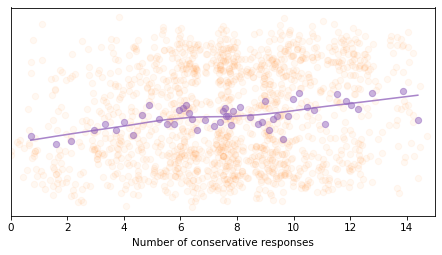

In [75]:
make_scatter(1988)

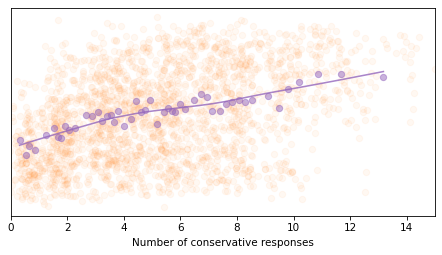

In [76]:
make_scatter(2018)

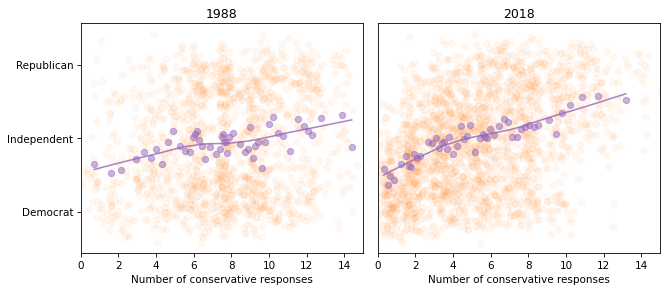

In [77]:
plt.figure(figsize=(9, 4))

for i, year in enumerate([1988, 2018]):
    plt.subplot(1, 2, i + 1)
    make_scatter(year)
    plt.title(year)
    if i == 0:
        plt.yticks(yticks, ylabels)


plt.savefig("alignment15.jpg", dpi=600)

## Counterfactual model

If we compare the average democrat in 2018 to the average democrat in 1988, they are substantially different, but that doesn't mean that the "average democrat" has changed their views, because the average democrat is not a person, it is a summary of a group of people, and that group of people changes over time.

Democrats in 2018 are not the same people as Democrats in 1988, for two reasons: generational replacement and partisan sorting.


This story makes it sound like we are following the same group of people over time and they are changing their minds.
But it's not the same group of people, and most of them are not changing their minds.
Rather:

* Generational replacement

* Assortation

The general shift to the left is driven by generational replacement.

The increasing gap between Democrats and Republicans is almost entirely due to assortation.


In [78]:
from statsmodels.miscmodels.ordinal_model import OrderedModel


def fit_ordinal(group, y="party7", x="conservatism"):
    data = group.dropna(subset=[x, y])
    if len(data) == 0:
        return None

    mod_log = OrderedModel(data[y], data[[x]], distr="logit")
    res_log = mod_log.fit(method="bfgs", disp=False)
    return res_log

In [79]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)


def predict_ordinal(result, group, x="conservatism"):
    group["party_pred"] = np.nan
    if result is None:
        return

    data = group.dropna(subset=[x])
    if len(data) == 0:
        return

    predicted = result.model.predict(result.params, exog=data[[x]])
    p = np.random.random(size=len(data))
    lt = p[:, None] < predicted.cumsum(axis=1)
    rows, cols = np.diff(lt, prepend=False).nonzero()
    group.loc[data.index, "party_pred"] = cols

In [80]:
gss["party7"] = gss["partyid"].replace(7, np.nan)

In [81]:
subset = gss.query("1973 <= year < 1985").copy()

In [82]:
result_fixed = fit_ordinal(subset)
result_fixed.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                 party7   Log-Likelihood:                -28150.
Model:                   OrderedModel   AIC:                         5.631e+04
Method:            Maximum Likelihood   BIC:                         5.637e+04
Date:                Wed, 03 Apr 2024                                         
Time:                        10:49:37                                         
No. Observations:               15044                                         
Df Residuals:                   15037                                         
Df Model:                           1                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
conservatism     0.0625      0.005     13.311      0.000       0.053       0.072
0.0/1.0         -1.1418      0.042    -27.402      0.000      -1.223      -1.060
1.0/2.0          0.2639      0.015     17.704      0.000       0.235       0.293
2.0/3.0         -0.6086      0.021    -29.060      0.000      -0.650      -0.568
3.0/4.0         -0.5953      0.022    -27.560      0.000      -0.638      -0.553
4.0/5.0         -0.7551      0.026    -29.039      0.000      -0.806      -0.704
5.0/6.0          0.2395      0.021     11.551      0.000       0.199       0.280
================================================================================
"""

In [83]:
subset["party_pred"] = np.nan
predict_ordinal(result_fixed, subset)

subset["party_pred"].value_counts()

1.0    3902
0.0    2545
5.0    2306
2.0    2093
3.0    1918
4.0    1405
6.0    1189
Name: party_pred, dtype: int64

In [84]:
subset["party7"].value_counts()

1.0    3871
0.0    2502
5.0    2252
2.0    2026
3.0    1938
4.0    1368
6.0    1154
Name: party7, dtype: int64

In [85]:
means = subset.groupby("party3")["conservatism"].mean()
means["Republican"] - means["Democrat"]

1.0641764005269518

In [86]:
def compute_diff(group):
    group["party_pred3"] = group["party_pred"].replace(recode_party)
    means = group.groupby("party_pred3")["conservatism"].mean()
    if len(means):
        return means["Republican"] - means["Democrat"]
    else:
        return np.nan

In [87]:
compute_diff(subset)

0.7970853434232819

In [88]:
def compute_diff_series(df, model=None):
    diff_series = pd.Series([], dtype=float)

    for name, group in df.groupby("year"):
        group = group.copy()
        result = model if model else fit_ordinal(group)
        predict_ordinal(result, group)
        diff_series.loc[name] = compute_diff(group)
        # print(name, diff_series.loc[name])

    return diff_series

In [89]:
np.random.seed(17)
diff_model = compute_diff_series(gss)

/tmp/ipykernel_653361/532577768.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  group.loc[data.index, "party_pred"] = cols


In [90]:
np.random.seed(17)
diff_fixed = compute_diff_series(gss, result_fixed)

/tmp/ipykernel_653361/532577768.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  group.loc[data.index, "party_pred"] = cols


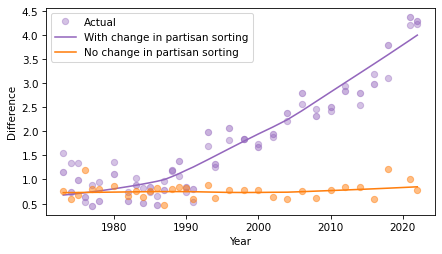

In [92]:
table = gss.pivot_table(index="year", columns="party3", values="conservatism")
diff = table["Republican"] - table["Democrat"]
diff.plot(style="o", color="C4", alpha=0.4, label="Actual")

plot_series_lowess(diff_model, color="C4", label="With change in partisan sorting")
plot_series_lowess(diff_fixed, color="C1", label="No change in partisan sorting")

decorate(xlabel="Year", ylabel="Difference")
plt.savefig("alignment16.jpg", dpi=600)

## Appendix: The Fifteen Questions

This appendix provides the wording of the fifteen questions from the General Social Survey that most distinguish liberals and conservatives, identified by topic and the GSS code name.

Homosexuality (homosex): What about sexual relations between two adults of the same sex--do you think it is always wrong, almost always wrong, wrong only sometimes, or not wrong at all?

Capital punishment (cappun): Do you favor or oppose the death penalty for persons convicted of murder?

Legal cannabis (grass): Do you think the use of marijuana should be made legal or not?

Abortion (abany): Please tell me whether or not you think it should be possible for a pregnant woman to obtain a legal abortion if the woman wants it for any reason?

Prayer in public schools (prayer): The United States Supreme Court has ruled that no state or local government may require the reading of the Lord's Prayer or Bible verses in public schools. What are your views on this--do you approve or disapprove of the court ruling?

Premarital sex (premarsx): There's been a lot of discussion about the way morals and attitudes about sex are changing in this country. If a man and woman have sex relations before marriage, do you think it is always wrong, almost always wrong, wrong only sometimes, or not wrong at all?

Divorce (divlaw): Should divorce in this country be easier or more difficult to obtain than it is now?

Spending on welfare (natfare) and the environment (natenvir): We are faced with many problems in this country, none of which can be solved easily or inexpensively. I'm going to name some of these problems, and for each one I'd like you to tell me whether you think we're spending too much money on it, too little money, or about the right amount.

* Welfare

* Improving and protecting the environment

Pornography (pornlaw): Which of these statements comes closest to your feelings about pornography laws? 

* There should be laws against the distribution of pornography whatever the age.

* There should be laws against the distribution of pornography to persons under 18.

* There should be no laws forbidding the distribution of pornography.

Open housing law (racopen): Suppose there is a community-wide vote on the general housing issue. There are two possible laws to vote on:

* One law says that a homeowner can decide for himself whom to sell his house to, even if he prefers not to sell to [people of a particular race].

* The second law says that a homeowner cannot refuse to sell to someone because of their race or color.

Which law would you vote for? 

Assisted suicide (letdie1): When a person has a disease that cannot be cured, do you think Doctors should be allowed by law to end the patient's life by some painless means if the patient and his family request it?

Women in politics (fepol): Tell me if you agree or disagree with this statement:  Most men are better suited emotionally for politics than are most women.

Gun control (gunlaw): Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?

Sex education (sexeduc): Would you be for or against sex education in the public schools?